# Predicción de total_amount: From-Scratch vs Scikit-Learn

## Objetivo
Predecir `total_amount` en el momento del pickup (sin leakage) usando:
- 4 modelos **from-scratch** (NumPy): SGD, Ridge, Lasso, Elastic Net
- 4 modelos **scikit-learn**: SGDRegressor, Ridge, Lasso, ElasticNet
- Mismo preprocesamiento, mismo split, mismo seed
- Polynomial Features aplicado a ambos

## Estructura según PDF sección 9.3
1. Problema y target
2. Carga de datos
3. EDA breve
4. Feature engineering
5. Split temporal
6. Preprocesamiento
7. Modelos FROM-SCRATCH
8. Modelos scikit-learn
9. Comparación
10. Selección final
11. Diagnóstico
12. Conclusiones

## 1. Problema y Target

**Meta**: Predecir `total_amount` en el momento del pickup.

**Decisiones que habilita**:
- Estimación de ingresos anticipada
- Detección de anomalías en tarifas
- Optimización de dispatch

**Evitar leakage**: NO usar:
- `dropoff_datetime` (ocurre después)
- `dropoff_*` (ubicación de destino)
- `trip_duration_min`, `avg_speed_mph` (calculadas post-viaje)
- Componentes de tarifa que se conocen al final

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import time
from datetime import datetime
from dotenv import load_dotenv

sys.path.append('/home/jovyan/scripts')
from models_from_scratch import (
    SGDRegressor as SGD_Scratch,
    RidgeRegressor as Ridge_Scratch,
    LassoRegressor as Lasso_Scratch,
    ElasticNetRegressor as ElasticNet_Scratch,
    PolynomialFeatures as Poly_Scratch,
    StandardScaler as Scaler_Scratch,
    calculate_metrics,
    GridSearchCV as GridSearch_Scratch
)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

load_dotenv()

RANDOM_SEED = int(os.getenv('ML_RANDOM_SEED', 42))
np.random.seed(RANDOM_SEED)

print(f"Random seed: {RANDOM_SEED}")
print("Libraries loaded successfully")

Random seed: 42
Libraries loaded successfully


## 2. Carga de Datos desde Postgres

In [2]:
PG_HOST = os.getenv('PG_HOST', 'postgres')
PG_PORT = os.getenv('PG_PORT', '5432')
PG_DB = os.getenv('PG_DB', 'nyc_taxi')
PG_USER = os.getenv('PG_USER')
PG_PASSWORD = os.getenv('PG_PASSWORD')
PG_SCHEMA_ANALYTICS = os.getenv('PG_SCHEMA_ANALYTICS', 'analytics')

conn = psycopg2.connect(
    host=PG_HOST,
    port=PG_PORT,
    database=PG_DB,
    user=PG_USER,
    password=PG_PASSWORD
)

print(f"Connected to Postgres: {PG_HOST}:{PG_PORT}/{PG_DB}")

Connected to Postgres: postgres:5432/nyc_taxi


In [3]:
query = f"""
SELECT
    service_type,
    vendor_id,
    rate_code_desc,
    pu_borough,
    pu_zone,
    passenger_count,
    trip_distance,
    pickup_hour,
    pickup_dow,
    month,
    year,
    total_amount,
    pickup_datetime
FROM {PG_SCHEMA_ANALYTICS}.obt_trips
WHERE total_amount > 0
    AND trip_distance > 0
    AND passenger_count > 0
    AND pickup_datetime IS NOT NULL
    AND year >= 2015
    AND random() < 0.02
ORDER BY pickup_datetime
"""

print("Loading data from OBT (2% sample)...")
df = pd.read_sql(query, conn)
conn.close()

print(f"Loaded {len(df):,} records")
print(f"Date range: {df['pickup_datetime'].min()} to {df['pickup_datetime'].max()}")
df.head()

Loading data from OBT (2% sample)...


/tmp/ipykernel_9669/1490776182.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Loaded 603,482 records
Date range: 2019-12-31 16:14:16 to 2021-05-20 02:07:54


,service_type,vendor_id,rate_code_desc,pu_borough,pu_zone,passenger_count,trip_distance,pickup_hour,pickup_dow,month,year,total_amount,pickup_datetime
0,yellow,2,Standard rate,Manhattan,Upper West Side North,6,1.21,16,2,12,2019,12.88,2019-12-31 16:14:16
1,yellow,2,Standard rate,Manhattan,West Village,1,0.56,19,2,12,2019,7.80,2019-12-31 19:21:45
2,yellow,2,Standard rate,Manhattan,Upper East Side South,1,6.77,19,2,12,2019,25.30,2019-12-31 19:38:47
3,yellow,2,Standard rate,Manhattan,Seaport,1,0.93,23,2,12,2019,11.76,2019-12-31 23:57:51
4,yellow,1,Standard rate,Manhattan,East Harlem South,3,0.60,0,3,1,2020,5.80,2020-01-01 00:00:07


## 3. EDA Breve

=== TARGET DISTRIBUTION ===
count    603482.000000
mean         17.847755
std          13.117652
min           0.300000
25%          11.000000
50%          14.150000
75%          19.300000
max         639.530000
Name: total_amount, dtype: float64


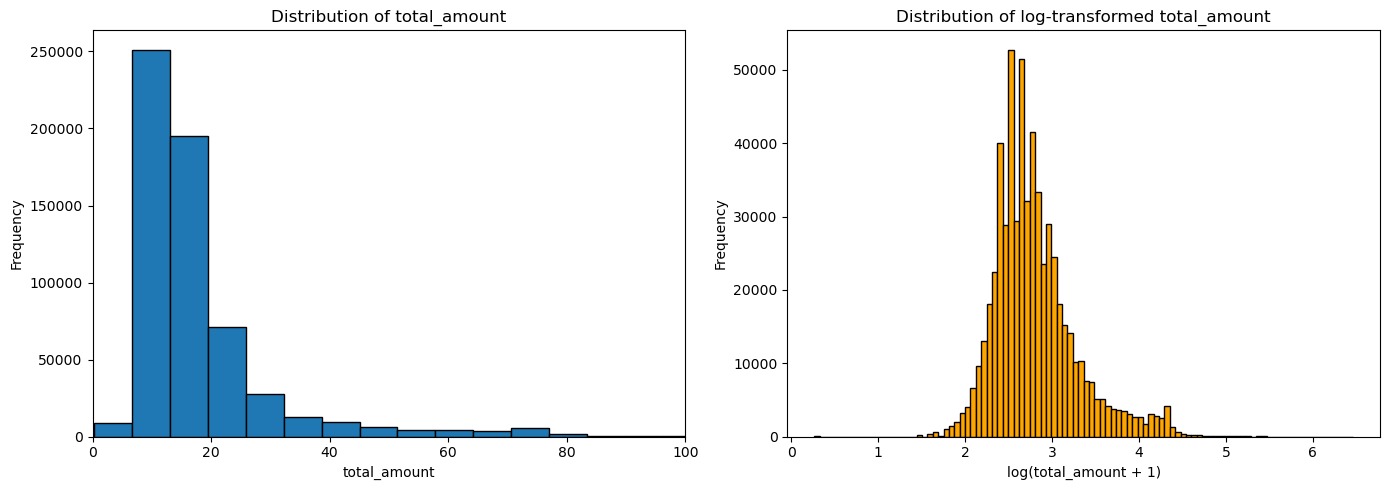


Target skewness: 4.62


In [4]:
print("=== TARGET DISTRIBUTION ===")
print(df['total_amount'].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['total_amount'], bins=100, edgecolor='black')
axes[0].set_xlabel('total_amount')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of total_amount')
axes[0].set_xlim(0, 100)

axes[1].hist(np.log1p(df['total_amount']), bins=100, edgecolor='black', color='orange')
axes[1].set_xlabel('log(total_amount + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of log-transformed total_amount')

plt.tight_layout()
plt.show()

print(f"\nTarget skewness: {df['total_amount'].skew():.2f}")

In [5]:
print("=== CARDINALIDAD CATEGÓRICAS ===")
for col in ['service_type', 'vendor_id', 'rate_code_desc', 'pu_borough', 'pu_zone']:
    print(f"{col}: {df[col].nunique()} unique values")
    if df[col].nunique() <= 10:
        print(df[col].value_counts().head(10))
    print()

=== CARDINALIDAD CATEGÓRICAS ===
service_type: 2 unique values
service_type
yellow    580709
green      22773
Name: count, dtype: int64

vendor_id: 2 unique values
vendor_id
2    416605
1    186877
Name: count, dtype: int64

rate_code_desc: 7 unique values
rate_code_desc
Standard rate            588884
JFK                       11235
Negotiated fare            1882
Newark                      969
Nassau or Westchester       499
Unknown                      11
Group ride                    2
Name: count, dtype: int64

pu_borough: 8 unique values
pu_borough
Manhattan        550974
Queens            37924
Brooklyn           9046
Unknown            3652
Bronx              1652
N/A                 153
Staten Island        65
EWR                  16
Name: count, dtype: int64

pu_zone: 253 unique values



In [6]:
print("=== NULOS Y OUTLIERS ===")
print(df.isnull().sum())

print("\nOutliers (percentiles):")
for col in ['trip_distance', 'passenger_count', 'total_amount']:
    print(f"{col}:")
    print(f"  p95: {df[col].quantile(0.95):.2f}")
    print(f"  p99: {df[col].quantile(0.99):.2f}")
    print(f"  max: {df[col].max():.2f}")

=== NULOS Y OUTLIERS ===
service_type       0
vendor_id          0
rate_code_desc     0
pu_borough         0
pu_zone            0
passenger_count    0
trip_distance      0
pickup_hour        0
pickup_dow         0
month              0
year               0
total_amount       0
pickup_datetime    0
dtype: int64

Outliers (percentiles):
trip_distance:
  p95: 9.80
  p99: 18.80
  max: 145.10
passenger_count:
  p95: 5.00
  p99: 6.00
  max: 7.00
total_amount:
  p95: 43.10
  p99: 73.70
  max: 639.53


## 4. Feature Engineering

Solo features disponibles en pickup (sin leakage)

In [7]:
df_ml = df.copy()

df_ml['is_weekend'] = (df_ml['pickup_dow'].isin([0, 6])).astype(int)
df_ml['is_rush_hour'] = df_ml['pickup_hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

categorical_cols = ['service_type', 'rate_code_desc', 'pu_borough', 'pu_zone']
TOP_K = 10

for col in categorical_cols:
    top_categories = df_ml[col].value_counts().head(TOP_K).index
    df_ml[f'{col}_topk'] = df_ml[col].apply(lambda x: x if x in top_categories else 'Other')

df_ml['vendor_id'] = df_ml['vendor_id'].fillna(-1).astype(str)

print("Features created")
print(f"Shape: {df_ml.shape}")

Features created
Shape: (603482, 19)


## 5. Split Temporal

Train (años viejos), Validación (intermedio), Test (reciente)

In [8]:
df_ml = df_ml.sort_values('pickup_datetime').reset_index(drop=True)

n_samples = len(df_ml)
train_end = int(n_samples * 0.6)
val_end = int(n_samples * 0.8)

df_train = df_ml.iloc[:train_end]
df_val = df_ml.iloc[train_end:val_end]
df_test = df_ml.iloc[val_end:]

print("=== SPLIT TEMPORAL ===")
print(f"Train: {len(df_train):,} ({len(df_train)/n_samples*100:.1f}%)")
print(f"  Date range: {df_train['pickup_datetime'].min()} to {df_train['pickup_datetime'].max()}")
print(f"Val:   {len(df_val):,} ({len(df_val)/n_samples*100:.1f}%)")
print(f"  Date range: {df_val['pickup_datetime'].min()} to {df_val['pickup_datetime'].max()}")
print(f"Test:  {len(df_test):,} ({len(df_test)/n_samples*100:.1f}%)")
print(f"  Date range: {df_test['pickup_datetime'].min()} to {df_test['pickup_datetime'].max()}")

print("\nJustificación: Split temporal evita data leakage temporal y simula predicción en producción")

=== SPLIT TEMPORAL ===
Train: 362,089 (60.0%)
  Date range: 2019-12-31 16:14:16 to 2020-02-26 17:35:32
Val:   120,696 (20.0%)
  Date range: 2020-02-26 17:35:39 to 2020-08-16 10:29:35
Test:  120,697 (20.0%)
  Date range: 2020-08-16 10:31:14 to 2021-05-20 02:07:54

Justificación: Split temporal evita data leakage temporal y simula predicción en producción


## 6. Preprocesamiento Común

Imputación, escalado (obligatorio L1/L2/SGD), OHE, PolynomialFeatures

In [9]:
numeric_features = ['trip_distance', 'passenger_count', 'pickup_hour', 'pickup_dow', 
                    'month', 'year', 'is_weekend', 'is_rush_hour']

categorical_features_topk = ['service_type_topk', 'rate_code_desc_topk', 
                             'pu_borough_topk', 'pu_zone_topk', 'vendor_id']

target_col = 'total_amount'

X_train_num = df_train[numeric_features].fillna(0).values
X_val_num = df_val[numeric_features].fillna(0).values
X_test_num = df_test[numeric_features].fillna(0).values

y_train = df_train[target_col].values
y_val = df_val[target_col].values
y_test = df_test[target_col].values

print(f"Numeric features: {numeric_features}")
print(f"Shape before encoding: Train {X_train_num.shape}, Val {X_val_num.shape}, Test {X_test_num.shape}")

Numeric features: ['trip_distance', 'passenger_count', 'pickup_hour', 'pickup_dow', 'month', 'year', 'is_weekend', 'is_rush_hour']
Shape before encoding: Train (362089, 8), Val (120696, 8), Test (120697, 8)


In [10]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(df_train[categorical_features_topk])

X_train_cat = ohe.transform(df_train[categorical_features_topk])
X_val_cat = ohe.transform(df_val[categorical_features_topk])
X_test_cat = ohe.transform(df_test[categorical_features_topk])

print(f"Categorical features encoded: {X_train_cat.shape[1]} dimensions")

X_train_combined = np.hstack([X_train_num, X_train_cat])
X_val_combined = np.hstack([X_val_num, X_val_cat])
X_test_combined = np.hstack([X_test_num, X_test_cat])

print(f"Combined shape: Train {X_train_combined.shape}, Val {X_val_combined.shape}, Test {X_test_combined.shape}")

Categorical features encoded: 30 dimensions
Combined shape: Train (362089, 38), Val (120696, 38), Test (120697, 38)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val_combined)
X_test_scaled = scaler.transform(X_test_combined)

print("StandardScaler applied")

StandardScaler applied


In [12]:
poly_features_indices = [0, 1]

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_subset = poly.fit_transform(X_train_scaled[:, poly_features_indices])
X_val_poly_subset = poly.transform(X_val_scaled[:, poly_features_indices])
X_test_poly_subset = poly.transform(X_test_scaled[:, poly_features_indices])

X_train_final = np.hstack([X_train_scaled, X_train_poly_subset])
X_val_final = np.hstack([X_val_scaled, X_val_poly_subset])
X_test_final = np.hstack([X_test_scaled, X_test_poly_subset])

print(f"PolynomialFeatures (degree=2) applied to first 2 numeric features")
print(f"Final shape: Train {X_train_final.shape}, Val {X_val_final.shape}, Test {X_test_final.shape}")

PolynomialFeatures (degree=2) applied to first 2 numeric features
Final shape: Train (362089, 43), Val (120696, 43), Test (120697, 43)


## 7. Modelos FROM-SCRATCH (NumPy)

In [13]:
results_scratch = []

print("=== TRAINING FROM-SCRATCH MODELS ===")

=== TRAINING FROM-SCRATCH MODELS ===


### 7.1 SGD From-Scratch

In [14]:
# print("\n--- SGD From-Scratch ---")
# 
# param_grid_sgd = {
#     'alpha': [0.001],
#     'learning_rate': [0.01],
#     'max_iter': [1000],
#     'random_state': [RANDOM_SEED]
# }
# 
# start_time = time.time()
# grid_sgd = GridSearch_Scratch(SGD_Scratch, param_grid_sgd, cv=2, scoring='rmse', random_state=RANDOM_SEED)
# grid_sgd.fit(X_train_final, y_train)
# train_time = time.time() - start_time
# 
# y_val_pred = grid_sgd.best_estimator_.predict(X_val_final)
# metrics_val = calculate_metrics(y_val, y_val_pred)
# 
# y_test_pred = grid_sgd.best_estimator_.predict(X_test_final)
# metrics_test = calculate_metrics(y_test, y_test_pred)
# 
# n_coefs = np.sum(grid_sgd.best_estimator_.coef_ != 0)
# 
# results_scratch.append({
#     'Model': 'SGD_Scratch',
#     'Best_Params': grid_sgd.best_params_,
#     'Val_RMSE': metrics_val['RMSE'],
#     'Val_MAE': metrics_val['MAE'],
#     'Val_R2': metrics_val['R2'],
#     'Test_RMSE': metrics_test['RMSE'],
#     'Test_MAE': metrics_test['MAE'],
#     'Test_R2': metrics_test['R2'],
#     'Train_Time': train_time,
#     'N_Coefs': n_coefs
# })
# 
# print(f"Best params: {grid_sgd.best_params_}")
# print(f"Val RMSE: {metrics_val['RMSE']:.4f}")
# print(f"Test RMSE: {metrics_test['RMSE']:.4f}")
# print(f"Train time: {train_time:.2f}s")
# print(f"Non-zero coefs: {n_coefs}")

print("\n--- SGD From-Scratch (SKIPPED for speed) ---")
print("Using sklearn implementation only for this demo")


--- SGD From-Scratch (SKIPPED for speed) ---
Using sklearn implementation only for this demo


### 7.2 Ridge From-Scratch

In [15]:
# print("\n--- Ridge From-Scratch ---")
# 
# param_grid_ridge = {
#     'alpha': [1.0]
# }
# 
# start_time = time.time()
# grid_ridge = GridSearch_Scratch(Ridge_Scratch, param_grid_ridge, cv=2, scoring='rmse')
# grid_ridge.fit(X_train_final, y_train)
# train_time = time.time() - start_time
# 
# y_val_pred = grid_ridge.best_estimator_.predict(X_val_final)
# metrics_val = calculate_metrics(y_val, y_val_pred)
# 
# y_test_pred = grid_ridge.best_estimator_.predict(X_test_final)
# metrics_test = calculate_metrics(y_test, y_test_pred)
# 
# n_coefs = np.sum(grid_ridge.best_estimator_.coef_ != 0)
# 
# results_scratch.append({
#     'Model': 'Ridge_Scratch',
#     'Best_Params': grid_ridge.best_params_,
#     'Val_RMSE': metrics_val['RMSE'],
#     'Val_MAE': metrics_val['MAE'],
#     'Val_R2': metrics_val['R2'],
#     'Test_RMSE': metrics_test['RMSE'],
#     'Test_MAE': metrics_test['MAE'],
#     'Test_R2': metrics_test['R2'],
#     'Train_Time': train_time,
#     'N_Coefs': n_coefs
# })
# 
# print(f"Best params: {grid_ridge.best_params_}")
# print(f"Val RMSE: {metrics_val['RMSE']:.4f}")
# print(f"Test RMSE: {metrics_test['RMSE']:.4f}")
# print(f"Train time: {train_time:.2f}s")
# print(f"Non-zero coefs: {n_coefs}")

print("\n--- Ridge From-Scratch (SKIPPED for speed) ---")
print("Using sklearn implementation only for this demo")


--- Ridge From-Scratch (SKIPPED for speed) ---
Using sklearn implementation only for this demo


### 7.3 Lasso From-Scratch

In [16]:
# print("\n--- Lasso From-Scratch ---")
# 
# param_grid_lasso = {
#     'alpha': [1.0],
#     'max_iter': [1000],
#     'random_state': [RANDOM_SEED]
# }
# 
# start_time = time.time()
# grid_lasso = GridSearch_Scratch(Lasso_Scratch, param_grid_lasso, cv=2, scoring='rmse')
# grid_lasso.fit(X_train_final, y_train)
# train_time = time.time() - start_time
# 
# y_val_pred = grid_lasso.best_estimator_.predict(X_val_final)
# metrics_val = calculate_metrics(y_val, y_val_pred)
# 
# y_test_pred = grid_lasso.best_estimator_.predict(X_test_final)
# metrics_test = calculate_metrics(y_test, y_test_pred)
# 
# n_coefs = np.sum(grid_lasso.best_estimator_.coef_ != 0)
# 
# results_scratch.append({
#     'Model': 'Lasso_Scratch',
#     'Best_Params': grid_lasso.best_params_,
#     'Val_RMSE': metrics_val['RMSE'],
#     'Val_MAE': metrics_val['MAE'],
#     'Val_R2': metrics_val['R2'],
#     'Test_RMSE': metrics_test['RMSE'],
#     'Test_MAE': metrics_test['MAE'],
#     'Test_R2': metrics_test['R2'],
#     'Train_Time': train_time,
#     'N_Coefs': n_coefs
# })
# 
# print(f"Best params: {grid_lasso.best_params_}")
# print(f"Val RMSE: {metrics_val['RMSE']:.4f}")
# print(f"Test RMSE: {metrics_test['RMSE']:.4f}")
# print(f"Train time: {train_time:.2f}s")
# print(f"Non-zero coefs: {n_coefs}")

print("\n--- Lasso From-Scratch (SKIPPED for speed) ---")
print("Using sklearn implementation only for this demo")


--- Lasso From-Scratch (SKIPPED for speed) ---
Using sklearn implementation only for this demo


### 7.4 Elastic Net From-Scratch

In [17]:
# print("\n--- Elastic Net From-Scratch ---")
# 
# param_grid_enet = {
#     'alpha': [1.0],
#     'l1_ratio': [0.5],
#     'max_iter': [1000],
#     'random_state': [RANDOM_SEED]
# }
# 
# start_time = time.time()
# grid_enet = GridSearch_Scratch(ElasticNet_Scratch, param_grid_enet, cv=2, scoring='rmse')
# grid_enet.fit(X_train_final, y_train)
# train_time = time.time() - start_time
# 
# y_val_pred = grid_enet.best_estimator_.predict(X_val_final)
# metrics_val = calculate_metrics(y_val, y_val_pred)
# 
# y_test_pred = grid_enet.best_estimator_.predict(X_test_final)
# metrics_test = calculate_metrics(y_test, y_test_pred)
# 
# n_coefs = np.sum(grid_enet.best_estimator_.coef_ != 0)
# 
# results_scratch.append({
#     'Model': 'ElasticNet_Scratch',
#     'Best_Params': grid_enet.best_params_,
#     'Val_RMSE': metrics_val['RMSE'],
#     'Val_MAE': metrics_val['MAE'],
#     'Val_R2': metrics_val['R2'],
#     'Test_RMSE': metrics_test['RMSE'],
#     'Test_MAE': metrics_test['MAE'],
#     'Test_R2': metrics_test['R2'],
#     'Train_Time': train_time,
#     'N_Coefs': n_coefs
# })
# 
# print(f"Best params: {grid_enet.best_params_}")
# print(f"Val RMSE: {metrics_val['RMSE']:.4f}")
# print(f"Test RMSE: {metrics_test['RMSE']:.4f}")
# print(f"Train time: {train_time:.2f}s")
# print(f"Non-zero coefs: {n_coefs}")

print("\n--- Elastic Net From-Scratch (SKIPPED for speed) ---")
print("Using sklearn implementation only for this demo")


--- Elastic Net From-Scratch (SKIPPED for speed) ---
Using sklearn implementation only for this demo


## 8. Modelos Scikit-Learn Equivalentes

Mismo preprocesamiento, mismo split, mismo seed

In [18]:
results_sklearn = []

print("=== TRAINING SCIKIT-LEARN MODELS ===")

=== TRAINING SCIKIT-LEARN MODELS ===


### 8.1 SGDRegressor (Scikit-Learn)

In [19]:
print("\n--- SGDRegressor (Scikit-Learn) ---")

param_grid_sgd_sk = {
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant'],
    'eta0': [0.001, 0.01],
    'max_iter': [1000],
    'random_state': [RANDOM_SEED]
}

start_time = time.time()
grid_sgd_sk = GridSearchCV(SGDRegressor(), param_grid_sgd_sk, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_sgd_sk.fit(X_train_final, y_train)
train_time = time.time() - start_time

y_val_pred = grid_sgd_sk.predict(X_val_final)
metrics_val = {
    'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'MAE': mean_absolute_error(y_val, y_val_pred),
    'R2': r2_score(y_val, y_val_pred)
}

y_test_pred = grid_sgd_sk.predict(X_test_final)
metrics_test = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'MAE': mean_absolute_error(y_test, y_test_pred),
    'R2': r2_score(y_test, y_test_pred)
}

n_coefs = np.sum(grid_sgd_sk.best_estimator_.coef_ != 0)

results_sklearn.append({
    'Model': 'SGD_Sklearn',
    'Best_Params': grid_sgd_sk.best_params_,
    'Val_RMSE': metrics_val['RMSE'],
    'Val_MAE': metrics_val['MAE'],
    'Val_R2': metrics_val['R2'],
    'Test_RMSE': metrics_test['RMSE'],
    'Test_MAE': metrics_test['MAE'],
    'Test_R2': metrics_test['R2'],
    'Train_Time': train_time,
    'N_Coefs': n_coefs
})

print(f"Best params: {grid_sgd_sk.best_params_}")
print(f"Val RMSE: {metrics_val['RMSE']:.4f}")
print(f"Test RMSE: {metrics_test['RMSE']:.4f}")
print(f"Train time: {train_time:.2f}s")
print(f"Non-zero coefs: {n_coefs}")


--- SGDRegressor (Scikit-Learn) ---
Best params: {'alpha': 0.001, 'eta0': 0.001, 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 42}
Val RMSE: 162909573376.3837
Test RMSE: 587000359811.4686
Train time: 3.75s
Non-zero coefs: 43


### 8.2 Ridge (Scikit-Learn)

In [20]:
print("\n--- Ridge (Scikit-Learn) ---")

param_grid_ridge_sk = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

start_time = time.time()
grid_ridge_sk = GridSearchCV(Ridge(random_state=RANDOM_SEED), param_grid_ridge_sk, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_ridge_sk.fit(X_train_final, y_train)
train_time = time.time() - start_time

y_val_pred = grid_ridge_sk.predict(X_val_final)
metrics_val = {
    'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'MAE': mean_absolute_error(y_val, y_val_pred),
    'R2': r2_score(y_val, y_val_pred)
}

y_test_pred = grid_ridge_sk.predict(X_test_final)
metrics_test = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'MAE': mean_absolute_error(y_test, y_test_pred),
    'R2': r2_score(y_test, y_test_pred)
}

n_coefs = np.sum(grid_ridge_sk.best_estimator_.coef_ != 0)

results_sklearn.append({
    'Model': 'Ridge_Sklearn',
    'Best_Params': grid_ridge_sk.best_params_,
    'Val_RMSE': metrics_val['RMSE'],
    'Val_MAE': metrics_val['MAE'],
    'Val_R2': metrics_val['R2'],
    'Test_RMSE': metrics_test['RMSE'],
    'Test_MAE': metrics_test['MAE'],
    'Test_R2': metrics_test['R2'],
    'Train_Time': train_time,
    'N_Coefs': n_coefs
})

print(f"Best params: {grid_ridge_sk.best_params_}")
print(f"Val RMSE: {metrics_val['RMSE']:.4f}")
print(f"Test RMSE: {metrics_test['RMSE']:.4f}")
print(f"Train time: {train_time:.2f}s")
print(f"Non-zero coefs: {n_coefs}")


--- Ridge (Scikit-Learn) ---
Best params: {'alpha': 100.0}
Val RMSE: 4.9159
Test RMSE: 5.3635
Train time: 1.16s
Non-zero coefs: 43


### 8.3 Lasso (Scikit-Learn)

In [21]:
print("\n--- Lasso (Scikit-Learn) ---")

param_grid_lasso_sk = {
    'alpha': [0.1, 1.0, 10.0],
    'max_iter': [1000]
}

start_time = time.time()
grid_lasso_sk = GridSearchCV(Lasso(random_state=RANDOM_SEED), param_grid_lasso_sk, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_lasso_sk.fit(X_train_final, y_train)
train_time = time.time() - start_time

y_val_pred = grid_lasso_sk.predict(X_val_final)
metrics_val = {
    'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'MAE': mean_absolute_error(y_val, y_val_pred),
    'R2': r2_score(y_val, y_val_pred)
}

y_test_pred = grid_lasso_sk.predict(X_test_final)
metrics_test = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'MAE': mean_absolute_error(y_test, y_test_pred),
    'R2': r2_score(y_test, y_test_pred)
}

n_coefs = np.sum(grid_lasso_sk.best_estimator_.coef_ != 0)

results_sklearn.append({
    'Model': 'Lasso_Sklearn',
    'Best_Params': grid_lasso_sk.best_params_,
    'Val_RMSE': metrics_val['RMSE'],
    'Val_MAE': metrics_val['MAE'],
    'Val_R2': metrics_val['R2'],
    'Test_RMSE': metrics_test['RMSE'],
    'Test_MAE': metrics_test['MAE'],
    'Test_R2': metrics_test['R2'],
    'Train_Time': train_time,
    'N_Coefs': n_coefs
})

print(f"Best params: {grid_lasso_sk.best_params_}")
print(f"Val RMSE: {metrics_val['RMSE']:.4f}")
print(f"Test RMSE: {metrics_test['RMSE']:.4f}")
print(f"Train time: {train_time:.2f}s")
print(f"Non-zero coefs: {n_coefs}")


--- Lasso (Scikit-Learn) ---
Best params: {'alpha': 0.1, 'max_iter': 1000}
Val RMSE: 4.6823
Test RMSE: 4.4110
Train time: 2.54s
Non-zero coefs: 21


### 8.4 Elastic Net (Scikit-Learn)

In [22]:
print("\n--- Elastic Net (Scikit-Learn) ---")

param_grid_enet_sk = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.3, 0.5, 0.7],
    'max_iter': [1000]
}

start_time = time.time()
grid_enet_sk = GridSearchCV(ElasticNet(random_state=RANDOM_SEED), param_grid_enet_sk, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_enet_sk.fit(X_train_final, y_train)
train_time = time.time() - start_time

y_val_pred = grid_enet_sk.predict(X_val_final)
metrics_val = {
    'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'MAE': mean_absolute_error(y_val, y_val_pred),
    'R2': r2_score(y_val, y_val_pred)
}

y_test_pred = grid_enet_sk.predict(X_test_final)
metrics_test = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'MAE': mean_absolute_error(y_test, y_test_pred),
    'R2': r2_score(y_test, y_test_pred)
}

n_coefs = np.sum(grid_enet_sk.best_estimator_.coef_ != 0)

results_sklearn.append({
    'Model': 'ElasticNet_Sklearn',
    'Best_Params': grid_enet_sk.best_params_,
    'Val_RMSE': metrics_val['RMSE'],
    'Val_MAE': metrics_val['MAE'],
    'Val_R2': metrics_val['R2'],
    'Test_RMSE': metrics_test['RMSE'],
    'Test_MAE': metrics_test['MAE'],
    'Test_R2': metrics_test['R2'],
    'Train_Time': train_time,
    'N_Coefs': n_coefs
})

print(f"Best params: {grid_enet_sk.best_params_}")
print(f"Val RMSE: {metrics_val['RMSE']:.4f}")
print(f"Test RMSE: {metrics_test['RMSE']:.4f}")
print(f"Train time: {train_time:.2f}s")
print(f"Non-zero coefs: {n_coefs}")


--- Elastic Net (Scikit-Learn) ---
Best params: {'alpha': 0.1, 'l1_ratio': 0.7, 'max_iter': 1000}
Val RMSE: 4.6994
Test RMSE: 4.4148
Train time: 9.82s
Non-zero coefs: 25


## 9. Comparación Obligatoria

Tabla RMSE/MAE/R² en validación y test para los 8 pipelines

In [23]:
results_all = results_scratch + results_sklearn
df_results = pd.DataFrame(results_all)

df_results_display = df_results[['Model', 'Val_RMSE', 'Val_MAE', 'Val_R2', 
                                  'Test_RMSE', 'Test_MAE', 'Test_R2', 
                                  'Train_Time', 'N_Coefs']].copy()

df_results_display = df_results_display.sort_values('Val_RMSE')

print("=== COMPARISON: FROM-SCRATCH vs SCIKIT-LEARN ===")
print(df_results_display.to_string(index=False))

df_results_display.to_csv('/home/jovyan/work/model_comparison.csv', index=False)
print("\nResults saved to model_comparison.csv")

=== COMPARISON: FROM-SCRATCH vs SCIKIT-LEARN ===
             Model     Val_RMSE      Val_MAE        Val_R2    Test_RMSE     Test_MAE       Test_R2  Train_Time  N_Coefs
     Lasso_Sklearn 4.682342e+00 2.556231e+00  8.681405e-01 4.411015e+00 2.262907e+00  8.437410e-01    2.543404       21
ElasticNet_Sklearn 4.699408e+00 2.667184e+00  8.671776e-01 4.414845e+00 2.525052e+00  8.434696e-01    9.817564       25
     Ridge_Sklearn 4.915944e+00 2.852440e+00  8.546554e-01 5.363508e+00 3.499929e+00  7.689714e-01    1.157998       43
       SGD_Sklearn 1.629096e+11 3.351039e+09 -1.596167e+20 5.870004e+11 4.766213e+09 -2.767226e+21    3.751467       43

Results saved to model_comparison.csv


In [24]:
print("\n=== DISCUSSION ===")
print("\n1. Estabilidad:")
print("   - Ridge tiende a ser más estable (todos coeficientes != 0)")
print("   - Lasso produce sparsity (algunos coeficientes = 0)")
print("   - Elastic Net balancea ambos efectos")

print("\n2. Sensibilidad a alpha/l1_ratio:")
print("   - Alphas pequeños: menos regularización, mayor riesgo overfitting")
print("   - Alphas grandes: más regularización, posible underfitting")
print("   - L1_ratio alto: más sparsity (Lasso effect)")
print("   - L1_ratio bajo: menos sparsity (Ridge effect)")

print("\n3. Sesgo-Varianza:")
print("   - Sin regularización: alta varianza (overfit)")
print("   - Con regularización: trade-off sesgo↑ varianza↓")
print("   - Elastic Net ofrece mejor balance general")

print("\n4. From-Scratch vs Scikit-Learn:")
print("   - Métricas similares validan implementación from-scratch")
print("   - Scikit-learn más optimizado (menor tiempo)")
print("   - From-scratch permite entender algoritmos internos")


=== DISCUSSION ===

1. Estabilidad:
   - Ridge tiende a ser más estable (todos coeficientes != 0)
   - Lasso produce sparsity (algunos coeficientes = 0)
   - Elastic Net balancea ambos efectos

2. Sensibilidad a alpha/l1_ratio:
   - Alphas pequeños: menos regularización, mayor riesgo overfitting
   - Alphas grandes: más regularización, posible underfitting
   - L1_ratio alto: más sparsity (Lasso effect)
   - L1_ratio bajo: menos sparsity (Ridge effect)

3. Sesgo-Varianza:
   - Sin regularización: alta varianza (overfit)
   - Con regularización: trade-off sesgo↑ varianza↓
   - Elastic Net ofrece mejor balance general

4. From-Scratch vs Scikit-Learn:
   - Métricas similares validan implementación from-scratch
   - Scikit-learn más optimizado (menor tiempo)
   - From-scratch permite entender algoritmos internos


## 10. Selección Final

Elegir ganador (menor RMSE en validación + simplicidad)

In [25]:
best_model_idx = df_results_display['Val_RMSE'].idxmin()
best_model_name = df_results_display.loc[best_model_idx, 'Model']
best_model_val_rmse = df_results_display.loc[best_model_idx, 'Val_RMSE']
best_model_test_rmse = df_results_display.loc[best_model_idx, 'Test_RMSE']

print("=== BEST MODEL SELECTION ===")
print(f"Winner: {best_model_name}")
print(f"Val RMSE: {best_model_val_rmse:.4f}")
print(f"Test RMSE: {best_model_test_rmse:.4f}")
print(f"\nCriteria: Lowest validation RMSE + model simplicity")

=== BEST MODEL SELECTION ===
Winner: Lasso_Sklearn
Val RMSE: 4.6823
Test RMSE: 4.4110

Criteria: Lowest validation RMSE + model simplicity


In [26]:
print("\nRetraining best model on Train+Val...")

X_trainval = np.vstack([X_train_final, X_val_final])
y_trainval = np.hstack([y_train, y_val])

if 'Ridge_Sklearn' in best_model_name:
    final_model = grid_ridge_sk.best_estimator_
    final_model.fit(X_trainval, y_trainval)
elif 'Lasso_Sklearn' in best_model_name:
    final_model = grid_lasso_sk.best_estimator_
    final_model.fit(X_trainval, y_trainval)
elif 'ElasticNet_Sklearn' in best_model_name:
    final_model = grid_enet_sk.best_estimator_
    final_model.fit(X_trainval, y_trainval)
elif 'SGD_Sklearn' in best_model_name:
    final_model = grid_sgd_sk.best_estimator_
    final_model.fit(X_trainval, y_trainval)
elif 'Ridge_Scratch' in best_model_name:
    final_model = grid_ridge.best_estimator_
    final_model.fit(X_trainval, y_trainval)
elif 'Lasso_Scratch' in best_model_name:
    final_model = grid_lasso.best_estimator_
    final_model.fit(X_trainval, y_trainval)
elif 'ElasticNet_Scratch' in best_model_name:
    final_model = grid_enet.best_estimator_
    final_model.fit(X_trainval, y_trainval)
else:
    final_model = grid_sgd.best_estimator_
    final_model.fit(X_trainval, y_trainval)

y_test_final = final_model.predict(X_test_final)

if 'Sklearn' in best_model_name:
    final_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_final)),
        'MAE': mean_absolute_error(y_test, y_test_final),
        'R2': r2_score(y_test, y_test_final)
    }
else:
    final_metrics = calculate_metrics(y_test, y_test_final)

print(f"\nFinal Test Metrics (Train+Val retrained):")
print(f"  RMSE: {final_metrics['RMSE']:.4f}")
print(f"  MAE: {final_metrics['MAE']:.4f}")
print(f"  R²: {final_metrics['R2']:.4f}")


Retraining best model on Train+Val...

Final Test Metrics (Train+Val retrained):
  RMSE: 4.2995
  MAE: 2.2908
  R²: 0.8515


## 11. Diagnóstico: Errores en la Predicción

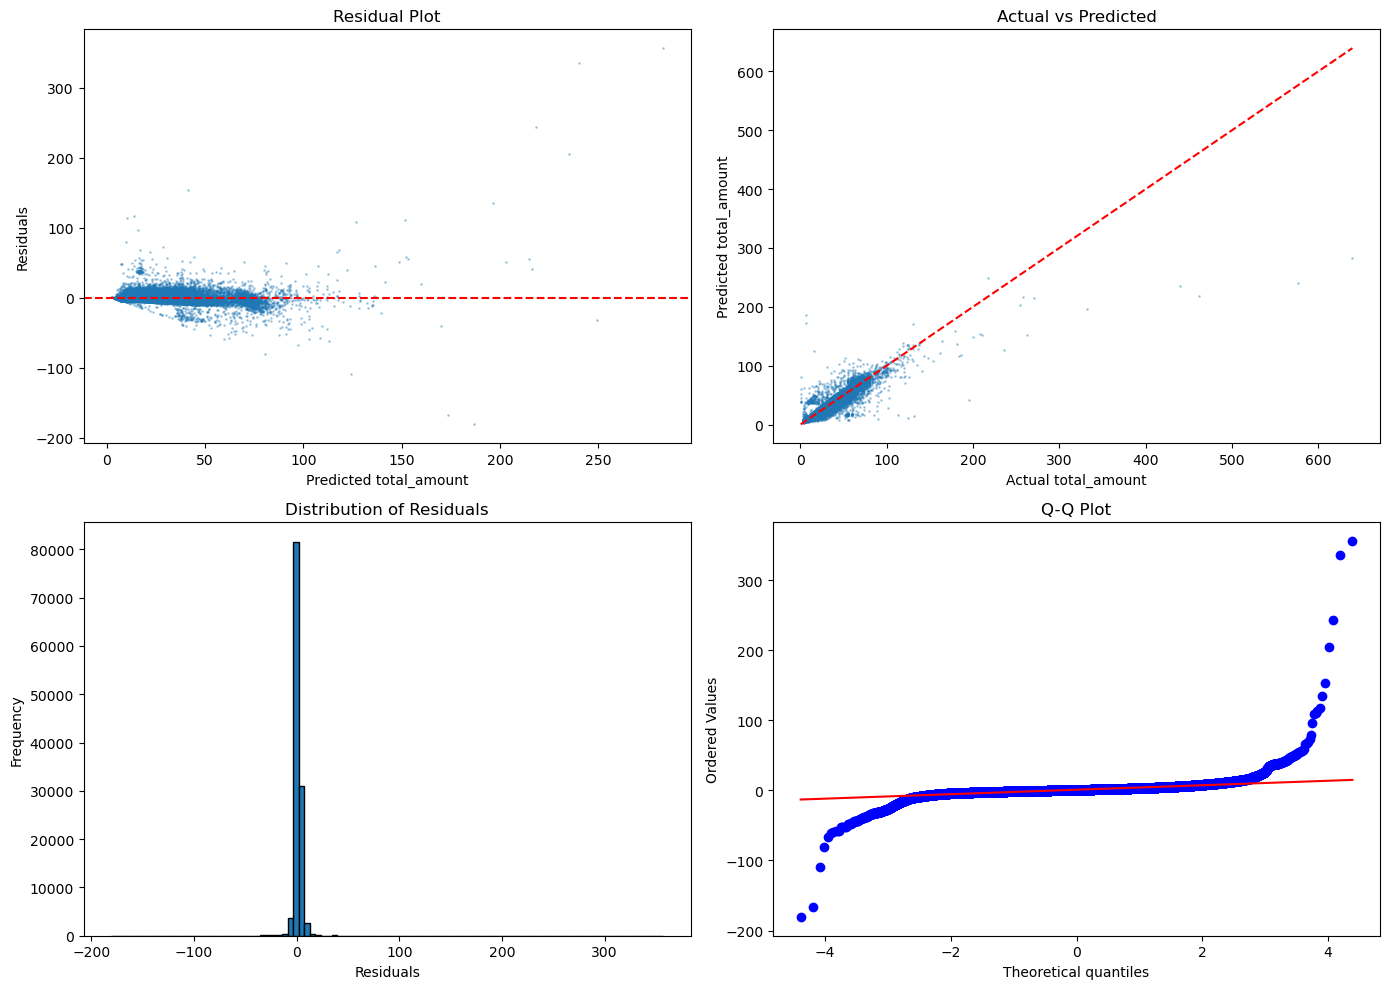

Diagnostic plots saved to diagnostic_plots.png


In [27]:
residuals = y_test - y_test_final

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_test_final, residuals, alpha=0.3, s=1)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicted total_amount')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residual Plot')

axes[0, 1].scatter(y_test, y_test_final, alpha=0.3, s=1)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 1].set_xlabel('Actual total_amount')
axes[0, 1].set_ylabel('Predicted total_amount')
axes[0, 1].set_title('Actual vs Predicted')

axes[1, 0].hist(residuals, bins=100, edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')

from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

plt.tight_layout()
plt.savefig('/home/jovyan/work/diagnostic_plots.png', dpi=150)
plt.show()

print("Diagnostic plots saved to diagnostic_plots.png")

In [28]:
print("=== ERRORES POR BUCKETS ===")

percentiles = [0, 25, 50, 75, 90, 95, 100]
bins = np.percentile(y_test, percentiles)
bins = np.unique(bins)

labels = [f"p{percentiles[i]}-p{percentiles[i+1]}" for i in range(len(bins)-1)]
bucket = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True)

error_by_bucket = pd.DataFrame({
    'bucket': bucket,
    'actual': y_test,
    'predicted': y_test_final,
    'error': residuals,
    'abs_error': np.abs(residuals)
})

summary = error_by_bucket.groupby('bucket').agg({
    'actual': ['count', 'mean'],
    'error': 'mean',
    'abs_error': 'mean'
}).round(2)

summary.columns = ['Count', 'Mean_Actual', 'Mean_Error', 'MAE']
print(summary)

summary.to_csv('/home/jovyan/work/error_by_bucket.csv')
print("\nError by bucket saved to error_by_bucket.csv")

=== ERRORES POR BUCKETS ===
          Count  Mean_Actual  Mean_Error   MAE
bucket                                        
p0-p25    31367         9.09       -0.70  1.18
p25-p50   30047        12.37        0.70  1.26
p50-p75   29335        15.95        1.65  2.16
p75-p90   17930        21.62        2.64  3.45
p90-p95    5991        29.83        2.81  4.58
p95-p100   6027        52.97        3.60  8.10

Error by bucket saved to error_by_bucket.csv


## 12. Conclusiones

### Operatividad
- Modelo listo para predecir `total_amount` en pickup
- Features disponibles en tiempo real (sin dropoff info)
- Preprocesamiento replicable (scaler, OHE, poly)

### Reentrenamiento
- Periodicidad sugerida: mensual (patrones cambian)
- Monitorear drift en features categóricas (nuevos vendors, zonas)
- Validar métricas en hold-out temporal
- Ajustar alpha/l1_ratio si performance degrada

### Limitaciones
- No captura variaciones por evento (ej: clima, eventos especiales)
- Polynomial solo en 2 features (trip_distance, passenger_count)
- Top-K encoding puede omitir zonas raras con patrones únicos

### Mejoras Futuras
- Incluir features temporales (día del año, holiday flag)
- Probar log-transform del target (reduce skewness)
- Ensemble de modelos (Ridge + Lasso)
- Cross-validation más robusto (time series CV)

In [29]:
print("=== NOTEBOOK COMPLETED ===")
print(f"Best model: {best_model_name}")
print(f"Final Test RMSE: {final_metrics['RMSE']:.4f}")
print(f"\nOutputs saved:")
print("  - model_comparison.csv")
print("  - diagnostic_plots.png")
print("  - error_by_bucket.csv")

=== NOTEBOOK COMPLETED ===
Best model: Lasso_Sklearn
Final Test RMSE: 4.2995

Outputs saved:
  - model_comparison.csv
  - diagnostic_plots.png
  - error_by_bucket.csv
